In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import glob

import torch

import numpy as np
import pandas as pd

import json

from PIL import Image
from matplotlib import pyplot
import seaborn as sns

from scipy.stats import pearsonr

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

In [2]:
from utils import get_score_from_embs, init_weights, log_likelihood

In [81]:
BATCH_SIZE = 64

EMB_DIMS = 768

VISION_WEIGHT_PATH = './weight/004/environmental/clip_vision.pt'

# VISION_WEIGHT_PATH = './weight/014/sac+logos+ava1-l14-linearMSE-single.pth'
# VISION_WEIGHT_PATH = './weight/014/sa_0_4_vit_l_14_linear.pth'

# VISION_WEIGHT_PATH = './weight/014/aesthetic-predictor_vision.pt'
# VISION_WEIGHT_PATH = './weight/014/improved-aesthetic-predictor_vision.pt'
# VISION_WEIGHT_PATH = './weight/014/nsfw-detector_vision.pt'

# TEXT_WEIGHT_PATH = './weight/004/environmental/clip_text.pt'
TEXT_WEIGHT_PATH = './weight/027/004-environmental-clip_vision-var.pt'
# TEXT_WEIGHT_PATH = './weight/027/clip_vision-var.pt'

LR = 1e-3

In [82]:
vision_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
vision_model.load_state_dict(torch.load(VISION_WEIGHT_PATH))

text_model = torch.nn.Linear(EMB_DIMS * 2, 1, bias=True).cuda().eval()
text_model.load_state_dict(torch.load(TEXT_WEIGHT_PATH))

<All keys matched successfully>

# load emb

In [5]:
text_emb_list = []
vision_emb_list = []

## from unmatched

In [6]:
VISION_EMB_PATH = 'data/environmental/clip_vision_emb.npz'
TEXT_EMB_PATH = 'data/environmental/clip_text_emb.npz'

In [7]:
npz = np.load(TEXT_EMB_PATH, allow_pickle=True)

text_file_paths = npz['file_paths']

text_positive_embs = npz['positive_pooler_outputs']
text_negative_embs = npz['negative_pooler_outputs']

text_path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(text_file_paths)}

In [8]:
npz = np.load(VISION_EMB_PATH, allow_pickle=True)

vision_file_paths = npz['file_paths']

vision_embs = npz['image_embeds']

vision_path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(vision_file_paths)}

In [9]:
file_paths = list(set(text_path_to_index.keys()) & set(vision_path_to_index.keys()))
path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(file_paths)}

In [10]:
indices = list(map(text_path_to_index.get, file_paths))

text_embs = np.concatenate([text_positive_embs[indices], text_negative_embs[indices]], axis=-1)

indices = list(map(vision_path_to_index.get, file_paths))

vision_embs = vision_embs[indices].astype('float32')

In [11]:
text_emb_list.append(text_embs)
vision_emb_list.append(vision_embs)

## from matched

In [12]:
EMB_DIRS = [
    './generated/1116/',
    './generated/1117/',
    './generated/1118/',
]

In [13]:
for emb_dir in EMB_DIRS:
    
    npz = np.load(os.path.join(emb_dir, 'clip_text_emb.npz'), allow_pickle=True)

    text_positive_embs = npz['positive_pooler_outputs']
    text_negative_embs = npz['negative_pooler_outputs']
    
    text_emb_list.append(np.concatenate([text_positive_embs, text_negative_embs], axis=-1))
    
    npz = np.load(os.path.join(emb_dir, 'clip_vision_emb.npz'), allow_pickle=True)

    vision_embs = npz['image_embeds'].astype('float32')
    
    vision_emb_list.append(vision_embs)

## from file system

In [14]:
CLIP_DIRS = [
    '../dataset/civitai-stable-diffusion-337k/clip/',
    '../dataset/midjourney-messages/clip/',
    '../dataset/scrap/leonardo/clip/',
]

In [15]:
for clip_dir in CLIP_DIRS:

    vision_embs = list()
    for fname in tqdm(os.listdir(clip_dir), leave=False):
        vision_embs.append(np.load(os.path.join(CLIP_DIR, fname)))
    vision_embs = np.concatenate(vision_embs, axis=0).astype('float32')

  0%|          | 0/80418 [00:00<?, ?it/s]

## concatenate

In [12]:
text_embs = np.concatenate(text_emb_list, axis=0)
vision_embs = np.concatenate(vision_emb_list, axis=0)

# compute score

In [83]:
vision_scores = get_score_from_embs(vision_embs, vision_model, BATCH_SIZE)
text_scores = get_score_from_embs(text_embs, text_model, BATCH_SIZE)

# vision_scores = get_score_from_embs(vision_embs, vision_model, BATCH_SIZE, preprocess=lambda x: x / x.norm(dim=-1, keepdim=True))

  0%|          | 0/708 [00:00<?, ?it/s]

  0%|          | 0/708 [00:00<?, ?it/s]

# build dataset

In [71]:
# embs = vision_embs
# scores = vision_scores

embs = text_embs
scores = vision_scores

In [32]:
train_indices, val_indices = train_test_split(np.arange(embs.shape[0]), test_size=0.2, random_state=42)
np.random.shuffle(train_indices)

In [33]:
train_x = torch.tensor(embs[train_indices]).half().cuda()
train_y = torch.tensor(scores[train_indices]).half().cuda()
val_x = torch.tensor(embs[val_indices]).half()
val_y = torch.tensor(scores[val_indices]).half()

# build model

In [18]:
model = torch.nn.Linear(train_x.shape[-1], 1).cuda()
# model = torch.nn.Sequential(
#     torch.nn.Linear(train_x.shape[-1], 64),
#     torch.nn.ReLU(),
#     torch.nn.Dropout(0.33),
#     torch.nn.Linear(64, 1)
# ).cuda()

init_weights(model)

In [19]:
LR = 1e-4
BATCH_SIZE = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [20]:
scaler = torch.cuda.amp.GradScaler()

mses, val_mses = list(), list()

for epoch in tqdm(range(1000)):
    
    model.train()
    
    for i in range(0, train_x.shape[0], BATCH_SIZE):

        with torch.cuda.amp.autocast(True):

            optimizer.zero_grad()

            y = model(train_x[i:i+BATCH_SIZE])

        # backward

        mse = torch.nn.functional.l1_loss(y, train_y[i:i+BATCH_SIZE, None])
        # bce = torch.nn.functional.binary_cross_entropy_with_logits(y, (train_y[i:i+BATCH_SIZE, None] > 0).half(), pos_weight=torch.tensor(10.).cuda())
        # mse = torch.nn.functional.mse_loss(y, train_y[i:i+BATCH_SIZE, None])
        
        loss = mse #+ bce * 0.1

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
        mses.append(mse.detach().cpu().numpy())
        
    with torch.no_grad():
        with torch.cuda.amp.autocast(True):
    
            for i in range(0, val_x.shape[0], BATCH_SIZE):
                y = model(val_x[i:i+BATCH_SIZE].cuda())

                mse = torch.nn.functional.l1_loss(y, val_y[i:i+BATCH_SIZE, None].cuda())
                # mse = torch.nn.functional.mse_loss(y, val_y[i:i+BATCH_SIZE, None].cuda())

                val_mses.append(mse.detach().cpu().numpy())
        
    if (epoch + 1) % 100 == 0:
        print(f'{np.mean(mses):.4f} {np.mean(val_mses):.4f}')
        mses, val_mses = list(), list()

  0%|          | 0/1000 [00:00<?, ?it/s]

1.6084 1.5893
1.3564 1.3684
1.3232 1.3437
1.3066 1.3340
1.2969 1.3299
1.2910 1.3289
1.2871 1.3289
1.2842 1.3294
1.2822 1.3300
1.2812 1.3308


# save model

In [24]:
# OUTPUT_PATH = './weight/014/improved-aesthetic-predictor_vision.pt'
# OUTPUT_PATH = './weight/014/aesthetic-predictor_vision.pt'
# OUTPUT_PATH = './weight/014/nsfw-detector_vision.pt'

# OUTPUT_PATH = './weight/014/improved-aesthetic-predictor_text.pt'
# OUTPUT_PATH = './weight/014/aesthetic-predictor_text.pt'
# OUTPUT_PATH = './weight/014/nsfw-detector_text.pt'

torch.save(model.state_dict(), OUTPUT_PATH)

In [25]:
# 

In [21]:
pred_scores = get_score_from_embs(embs, model, BATCH_SIZE)
# pred_scores = get_score_from_embs(embs, vision_model, BATCH_SIZE)

  0%|          | 0/12 [00:00<?, ?it/s]

In [22]:
df = pd.DataFrame(zip(file_paths, text_scores, pred_scores, vision_scores), columns=['file_path', 'uncertainty', 'pred_score', 'vision_score'])

In [ ]:
environmental/0054/053045

In [ ]:
environmental/0011/010013	

In [32]:
df.query('uncertainty < .05 and vision_score > 7')

,file_path,uncertainty,pred_score,vision_score
2356,environmental/0064/063804,0.041821,5.046621,8.024743


In [29]:
js = json.load(open('./data/environmental/prompt.json'))

In [33]:
[i for i in js.values() if i['file_path'].startswith('environmental/0064/063804')]

[{'file_path': 'environmental/0064/063804_data.msgpack',
  'creation_time': '2023-11-11 03:52:04',
  'job_uuid': 'd163f997-4d63-4d7b-8cfb-5b714fa6d8d8',
  'positive_prompt': "side scrolling concept art, 2D environmental art side scrolling, the moons of jupiter, pulp fiction, level design, the planet titan, snes, illustration, loney tunes style, cute, 2d, 2d game character, on a sunny morning, alayna lemmer, ultra-detailed, cinematic, short hair, is a sunny day and the aren't clouds in the sky, gemma correll, shot on 35mm lens, fine details, apocalypse",
  'negative_prompt': 'body dysmorphia 0025415, hyper - realistic image with cinematic quality, color, straws, city, anime, realistic photo, glasses, mock up, shadows, photo realism, colour, outline, text fonts letters watermark words typography slogans signature, mechanical elements gender, text shadow font watermark, words, 97877'}]

# load rank data

In [14]:
INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'

In [15]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/49097 [00:00<?, ?it/s]

In [16]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

In [17]:
indices_1 = list(map(path_to_index.get, ordered_pairs['image_1']))
indices_2 = list(map(path_to_index.get, ordered_pairs['image_2']))

# visualization

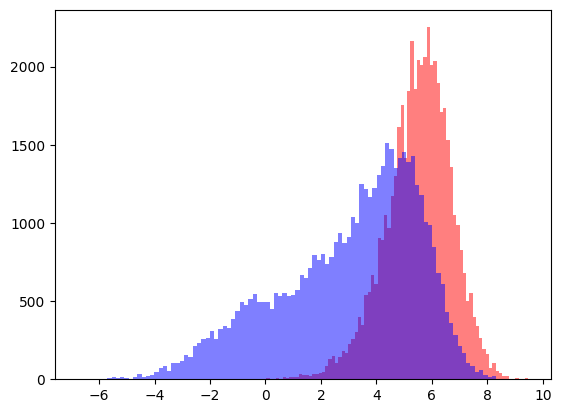

In [76]:
# y0, y1, delta = train_y0, train_y1, train_delta

y0, y1 = pred_scores[indices_1], pred_scores[indices_2]
# y0, y1 = vision_scores[indices_1], vision_scores[indices_2]
# y0, y1 = text_scores[indices_1], text_scores[indices_2]

_ = pyplot.hist(y0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(y1, bins=100, color='b', alpha=0.5)

In [77]:
- torch.log(torch.sigmoid(torch.tensor(y0 - y1).float())).mean()

tensor(0.3649)

In [78]:
# exp0 = np.exp(pred_scores[indices_1] + text_scores[indices_1] / 2)
# exp1 = np.exp(pred_scores[indices_2] + text_scores[indices_2] / 2)

exp0 = np.exp(pred_scores[indices_1] + pred_uncertainty[indices_1] / 2)
exp1 = np.exp(pred_scores[indices_2] + pred_uncertainty[indices_2] / 2)

- torch.log(torch.tensor(exp0 / (exp0 + exp1)).float()).mean()

tensor(0.3575)

/tmp/ipykernel_2038102/2635890510.py:4: RuntimeWarning: overflow encountered in exp
  exp0 = np.exp(pred_scores[indices_1] + pred_uncertainty[indices_1] * s / 2)
/tmp/ipykernel_2038102/2635890510.py:6: RuntimeWarning: invalid value encountered in divide
  ces.append(- torch.log(torch.tensor(exp0 / (exp0 + exp1)).float()).mean().detach().cpu().numpy())
/tmp/ipykernel_2038102/2635890510.py:6: RuntimeWarning: overflow encountered in add
  ces.append(- torch.log(torch.tensor(exp0 / (exp0 + exp1)).float()).mean().detach().cpu().numpy())
/tmp/ipykernel_2038102/2635890510.py:5: RuntimeWarning: overflow encountered in exp
  exp1 = np.exp(pred_scores[indices_2] + pred_uncertainty[indices_2] * s / 2)


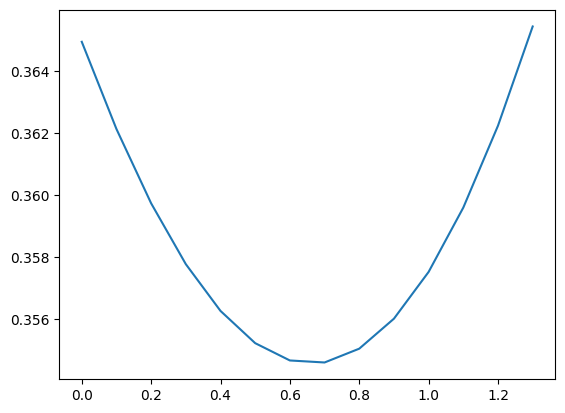

In [79]:
ss = np.arange(100) / 10.
ces = list()
for s in ss:
    exp0 = np.exp(pred_scores[indices_1] + pred_uncertainty[indices_1] * s / 2)
    exp1 = np.exp(pred_scores[indices_2] + pred_uncertainty[indices_2] * s / 2)
    ces.append(- torch.log(torch.tensor(exp0 / (exp0 + exp1)).float()).mean().detach().cpu().numpy())

pyplot.plot(ss, ces)

# build rank dataset

## 2

In [44]:
embs = np.stack([text_embs[indices_1], text_embs[indices_2]], axis=-2)
scores = np.stack([vision_scores[indices_1], vision_scores[indices_2]], axis=-1)

In [45]:
train_indices, val_indices = train_test_split(np.arange(embs.shape[0]), test_size=0.2, random_state=42)
np.random.shuffle(train_indices)

In [46]:
train_x = torch.tensor(embs[train_indices]).half().cuda()
train_y = torch.tensor(scores[train_indices]).half().cuda()
val_x = torch.tensor(embs[val_indices]).half()
val_y = torch.tensor(scores[val_indices]).half()

In [66]:
model = torch.nn.Linear(train_x.shape[-1], 2).cuda()

init_weights(model)

In [67]:
LR = 1e-3
BATCH_SIZE = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = AGC(optimizer)

In [38]:
lls, sigmas, mses, val_mses = list(), list(), list(), list()

for epoch in tqdm(range(500)):
    
    model.train()
    
    for i in range(0, train_x.shape[0], BATCH_SIZE):

        optimizer.zero_grad()

        mu_sigma = model(train_x[i:i+BATCH_SIZE].float())
            
        # backward

        ll = log_likelihood(
            mu_sigma[..., 0], mu_sigma[..., 1] ** 2, 
            train_y[i:i+BATCH_SIZE], 
            # clip=10.
        )
        
        mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], train_y[i:i+BATCH_SIZE].float())

        loss = ll + mse

        loss.backward()
        optimizer.step()
    
        lls.append(ll.detach().cpu().numpy())
        sigmas.append(torch.abs(mu_sigma[..., 1]).mean().detach().cpu().numpy())
        mses.append(mse.detach().cpu().numpy())
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(True):
            
            mu_sigma = model(val_x.cuda())
            
            mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], val_y.cuda())
    
            val_mses.append(mse.detach().cpu().numpy())
    
    if (epoch + 1) % 100 == 0:
        
        print(f'{np.mean(lls):.4f} {np.mean(sigmas):.4f} {np.mean(mses):.4f} {np.mean(val_mses):.4f}')
        lls, sigmas, mses, val_mses = list(), list(), list(), list()

  0%|          | 0/500 [00:00<?, ?it/s]

1.1065 2.2375 2.6691 2.8859
1.1937 2.6512 2.6887 2.9310
1.0908 2.1258 2.6503 2.9135
1.0080 1.7628 2.6489 2.9339
0.9818 1.6712 2.6386 2.9397


In [68]:
lls, sigmas, mses, val_mses = list(), list(), list(), list()

for epoch in tqdm(range(1000)):
    
    model.train()
    
    for i in range(0, train_x.shape[0], BATCH_SIZE):

        optimizer.zero_grad()

        mu_sigma = model(train_x[i:i+BATCH_SIZE].float())
            
        # backward

        ll = log_likelihood(
            mu_sigma[..., 0], mu_sigma[..., 1] ** 2, 
            train_y[i:i+BATCH_SIZE], 
            # clip=10.
        )
        
        y0 = mu_sigma[..., 0, 0] + mu_sigma[..., 0, 1] ** 2 / 2
        y1 = mu_sigma[..., 1, 0] + mu_sigma[..., 1, 1] ** 2 / 2
        
        y = torch.stack([y0, y1], dim=-1)

        mse = torch.nn.functional.cross_entropy(y, torch.zeros((y.shape[0], )).long().cuda())
        
        # mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], train_y[i:i+BATCH_SIZE].float())

        loss = ll + mse #+ bce

        loss.backward()
        optimizer.step()
    
        lls.append(ll.detach().cpu().numpy())
        sigmas.append(torch.abs(mu_sigma[..., 1]).mean().detach().cpu().numpy())
        mses.append(mse.detach().cpu().numpy())
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(True):
            
            mu_sigma = model(val_x.cuda())
            
            mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], val_y.cuda())
    
            val_mses.append(mse.detach().cpu().numpy())
    
    if (epoch + 1) % 100 == 0:
        
        print(f'{np.mean(lls):.4f} {np.mean(sigmas):.4f} {np.mean(mses):.4f} {np.mean(val_mses):.4f}')
        lls, sigmas, mses, val_mses = list(), list(), list(), list()

  0%|          | 0/1000 [00:00<?, ?it/s]

5.6581 4.6001 1.1346 6.4190
1.6384 4.4403 0.8674 5.7414
1.5360 3.9772 0.6502 4.9324
1.3178 2.9831 0.4874 3.9208
1.1229 2.0508 0.4111 3.2116
1.0584 1.8297 0.3804 3.0105
1.0196 1.7281 0.3649 2.9358
0.9948 1.6655 0.3583 2.9112
0.9780 1.6258 0.3556 2.9070
0.9630 1.5956 0.3542 2.9044


In [72]:
with torch.no_grad():
    with torch.cuda.amp.autocast(True):
        
        x = torch.tensor(embs).half()
        
        mu_sigma = model(x.cuda()).detach().cpu().numpy()
        pred_scores = mu_sigma[..., 0]
        pred_uncertainty = mu_sigma[..., 1] ** 2

PearsonRResult(statistic=-0.2993351267922213, pvalue=0.0)
PearsonRResult(statistic=0.7835174129959885, pvalue=0.0)


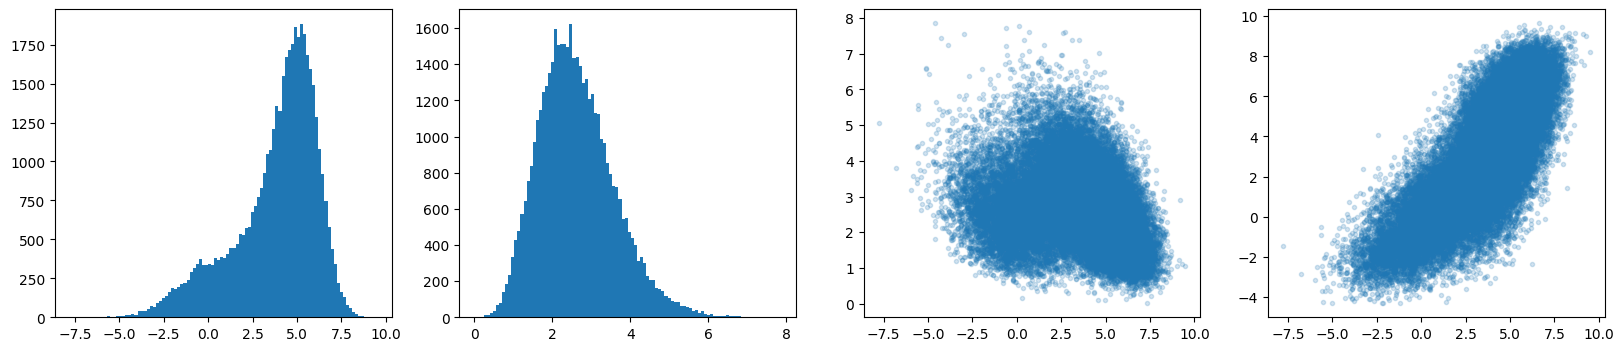

In [75]:
pyplot.figure(figsize=(20, 4))

pyplot.subplot(1, 4, 1)

_ = pyplot.hist(pred_scores, bins=100)

pyplot.subplot(1, 4, 2)

_ = pyplot.hist(pred_uncertainty, bins=100)

pyplot.subplot(1, 4, 3)

print(pearsonr(pred_scores, pred_uncertainty))
pyplot.plot(pred_scores, pred_uncertainty, '.', alpha=0.2)

pyplot.subplot(1, 4, 4)

print(pearsonr(pred_scores, scores))
pyplot.plot(pred_scores, scores, '.', alpha=0.2)

PearsonRResult(statistic=0.5140901875587005, pvalue=0.0)
PearsonRResult(statistic=0.046980841025077894, pvalue=1.450584934864415e-23)


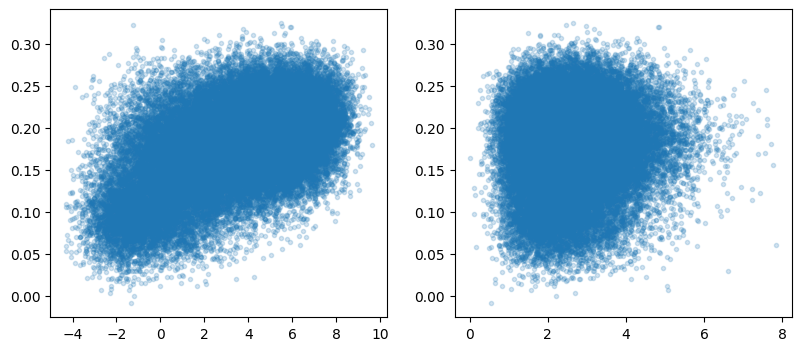

In [84]:
pyplot.figure(figsize=(20, 4))

pyplot.subplot(1, 4, 3)

print(pearsonr(vision_scores, text_scores))
pyplot.plot(vision_scores, text_scores, '.', alpha=0.2)

pyplot.subplot(1, 4, 4)

print(pearsonr(pred_uncertainty, text_scores))
pyplot.plot(pred_uncertainty, text_scores, '.', alpha=0.2)